what type of films should bluckboster focus on stocking? is it different based on location? 
- What countries as a whole prefer
- what the world by country prefers
- is it the same as taking customers as one group
- what is the least popular by the same metrics

Import whats needed

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Read the needed files,
errors due to last_update causing conflict so removing it

In [57]:
def drop_last_update(df):
    return df.drop(
        columns=[c for c in df.columns if c == "last_update"], errors="ignore"
    )


film = drop_last_update(pd.read_csv("../data/film.csv"))
film_category = drop_last_update(pd.read_csv("../data/film_category.csv"))
category = drop_last_update(pd.read_csv("../data/category.csv"))
inventory = drop_last_update(pd.read_csv("../data/inventory.csv"))
rental = drop_last_update(pd.read_csv("../data/rental.csv"))
customer = drop_last_update(pd.read_csv("../data/customer.csv"))
address = drop_last_update(pd.read_csv("../data/address.csv"))
city = drop_last_update(pd.read_csv("../data/city.csv"))
country = drop_last_update(pd.read_csv("../data/country.csv"))

Merge them to create a singular dataframe

In [58]:
# Film, Film Category, Category
df = film.merge(film_category, on="film_id").merge(category, on="category_id")

# Add inventory
df = df.merge(inventory, on="film_id")

# Add rentals
df = df.merge(rental, on="inventory_id")

# Add customer
df = df.merge(customer, on="customer_id")

# Add address, city, country
df = (
    df.merge(address, on="address_id")
    .merge(city, on="city_id")
    .merge(country, on="country_id")
)

In [59]:
df.head()

,film_id,title,description,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,...,active,address,address2,district,city_id,postal_code,phone,city,country_id,country
0,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,...,1,1370 Le Mans Avenue,NaN,Brunei and Muara,53,52163.0,3.456798e+11,Bandar Seri Begawan,16,Brunei
1,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,...,1,1479 Rustenburg Boulevard,NaN,Southern Tagalog,527,18727.0,7.277855e+11,Tanza,75,Philippines
2,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,...,1,81 Hodeida Way,NaN,Rajasthan,231,55561.0,2.507677e+11,Jaipur,44,India
3,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,...,1,64 Korla Street,NaN,Mwanza,347,25145.0,5.103832e+11,Mwanza,93,Tanzania
4,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,...,1,1917 Kumbakonam Parkway,NaN,Vojvodina,368,11892.0,6.981825e+11,Novi Sad,108,Yugoslavia


grab information need for question, 
film, times rented, country rented in, and category of film

In [60]:
# Drop rows with missing values in 'title', 'name', or 'country'
clean_df = df.dropna(subset=["title", "name", "country"])

# Drop duplicates based on the same columns and rental_id
clean_df = clean_df.drop_duplicates(subset=["title", "name", "country", "rental_id"])


result = (
    clean_df.groupby(["title", "name", "country"])
    .agg(times_rented=("rental_id", "count"))
    .reset_index()
    .rename(columns={"name": "category"})
)

In [61]:
result.head()

,title,category,country,times_rented
0,Academy Dinosaur,Documentary,Argentina,1
1,Academy Dinosaur,Documentary,Bolivia,1
2,Academy Dinosaur,Documentary,Brazil,2
3,Academy Dinosaur,Documentary,India,2
4,Academy Dinosaur,Documentary,Indonesia,1


how often is each category rented by country

In [62]:
category_country = (
    clean_df.groupby(["name", "country"])
    .agg(times_rented=("rental_id", "count"))
    .reset_index()
    .rename(columns={"name": "category"})
)

In [63]:
category_country.head()

,category,country,times_rented
0,Action,Afghanistan,1
1,Action,Algeria,5
2,Action,American Samoa,1
3,Action,Angola,3
4,Action,Anguilla,1


What is the the top category in each country

In [64]:
top_category_each_country = (
    category_country.sort_values(["country", "times_rented"], ascending=[True, False])
    .groupby("country")
    .head(1)
    .reset_index(drop=True)
)
top_category_each_country

,category,country,times_rented
0,Comedy,Afghanistan,3
1,Sci-Fi,Algeria,12
2,Sports,American Samoa,5
3,Animation,Angola,7
4,Travel,Anguilla,5
...,...,...,...
103,Drama,Vietnam,16
104,Animation,"Virgin Islands, U.S.",7
105,Action,Yemen,15
106,Animation,Yugoslavia,7


How many countries have each category as the top category


In [65]:
category_top_counts = (
    top_category_each_country["category"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "category"})
)
category_top_counts

,category,count
0,Animation,18
1,Sports,13
2,Sci-Fi,12
3,Action,11
4,Foreign,10
5,Documentary,7
6,Classics,7
7,Family,6
8,Children,6
9,Drama,5


how many categories are there in the original df

In [66]:
unique_categories = clean_df["name"].unique()
unique_categories

array(['Music', 'Horror', 'Drama', 'Documentary', 'Family', 'Foreign',
       'Comedy', 'Sports', 'Animation', 'Action', 'New', 'Sci-Fi',
       'Classics', 'Games', 'Children', 'Travel'], dtype=object)

new is the only one not featured what films come under new? is there an error?

In [67]:
new_films = clean_df[clean_df["name"] == "New"]["title"]
new_films.unique()

array(['Amistad Midsummer', 'Angels Life', 'Apocalypse Flamingos',
       'Attraction Newton', 'Birds Perdition', 'Boulevard Mob',
       'Brannigan Sunrise', 'Breakfast Goldfinger', 'Breaking Home',
       'Butterfly Chocolat', 'Chaplin License', 'Cleopatra Devil',
       'Clyde Theory', 'Day Unfaithful', 'Destiny Saturday',
       'Dragonfly Strangers', 'Eagles Panky', 'Earth Vision',
       'Ending Crowds', 'Eve Resurrection', 'Fatal Haunted',
       'Flamingos Connecticut', 'Flash Wars', 'Frontier Cabin',
       'Godfather Diary', 'Hours Rage', 'Idaho Love',
       'Interview Liaisons', 'Jekyll Frogmen', 'Jumanji Blade',
       'Jungle Closer', 'Loverboy Attacks', 'Mask Peach', 'Maiden Home',
       'Mannequin Worst', 'Mine Titans', 'Money Harold', 'Nuts Ties',
       'Oklahoma Jumanji', 'Phantom Glory', 'Pianist Outfield',
       'Platoon Instinct', 'Pluto Oleander', 'Redemption Comforts',
       'Ridgemont Submarine', 'Run Pacific', 'Runaway Tenenbaums',
       'Salute Apollo', '

Does not seem to be an error as there seems to be a range of films

most popular films in most countries seem to be Animation, Sports, and Sci-Fi leasst popular seem to be New, Music, and Travel

what countries rent the most?

In [68]:

country_rentals = result.groupby("country")["times_rented"].sum().reset_index()

country_rentals = country_rentals.sort_values(by="times_rented", ascending=False)

country_rentals

,country,times_rented
42,India,1572
21,China,1403
101,United States,941
58,Mexico,796
48,Japan,793
...,...,...
55,Madagascar,22
64,Nepal,22
2,American Samoa,20
0,Afghanistan,18


how does popularity by country compare to total popularity 

In [69]:
category_rentals = (
    clean_df.groupby("name")
    .agg(total_rentals=("rental_id", "count"))
    .reset_index()
    .sort_values(by="total_rentals", ascending=False)
    .rename(columns={"name": "category"})
)

category_rentals

,category,total_rentals
14,Sports,1171
1,Animation,1160
0,Action,1107
13,Sci-Fi,1096
7,Family,1094
6,Drama,1054
5,Documentary,1046
8,Foreign,1031
9,Games,963
2,Children,943


sports and animation still in the top 3 and sci-fi and action have swapped but overall similar, new is much higher though music and travel still quite low

Could look at amount of films per category and see if variety may impact rental amounts

Rentals by Category

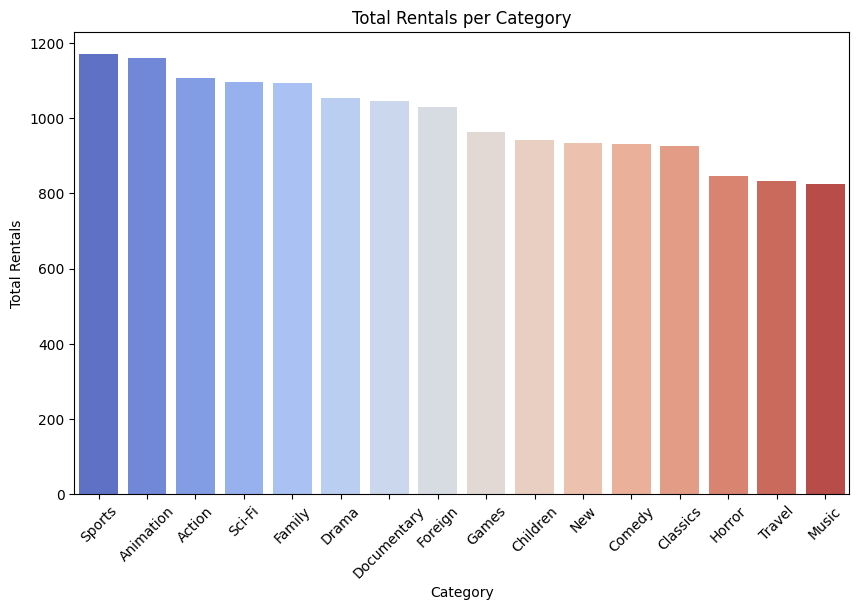

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(data=category_rentals, x="category", y="total_rentals", palette="coolwarm", hue='category', legend=False)
plt.title("Total Rentals per Category")
plt.xlabel("Category")
plt.ylabel("Total Rentals")
plt.xticks(rotation=45)
plt.show()

Graph shows that worldwide Sports is rented the most often whereas Music is rented the least

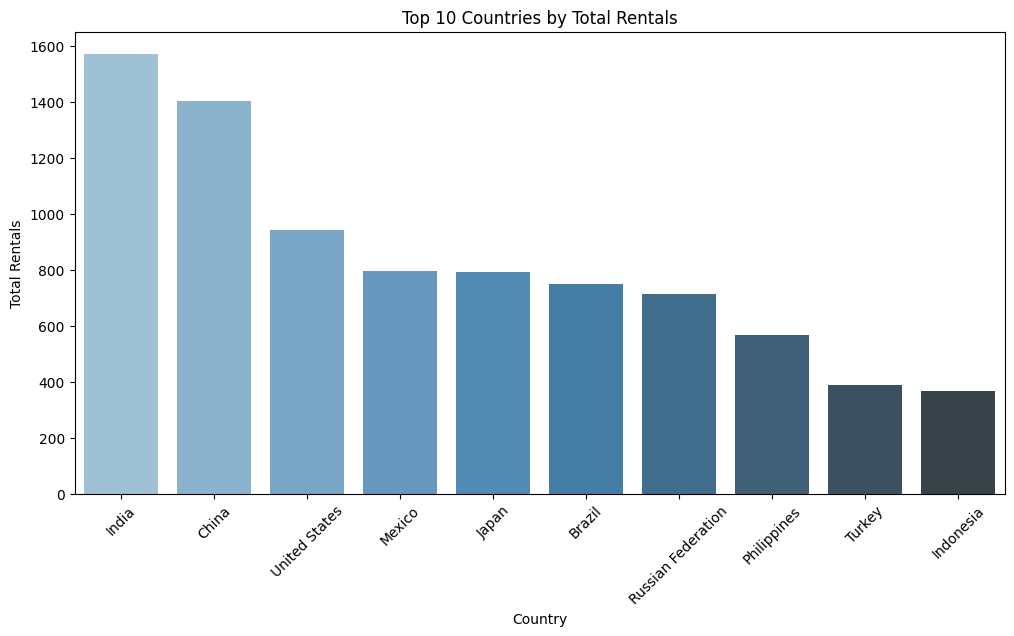

In [71]:
top_10_countries = country_rentals.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_countries, x="country", y="times_rented", palette="Blues_d", hue='country', legend=False)
plt.title("Top 10 Countries by Total Rentals")
plt.xlabel("Country")
plt.ylabel("Total Rentals")
plt.xticks(rotation=45)
plt.show()

Shows the 10 countries who rent the most movies with India leading

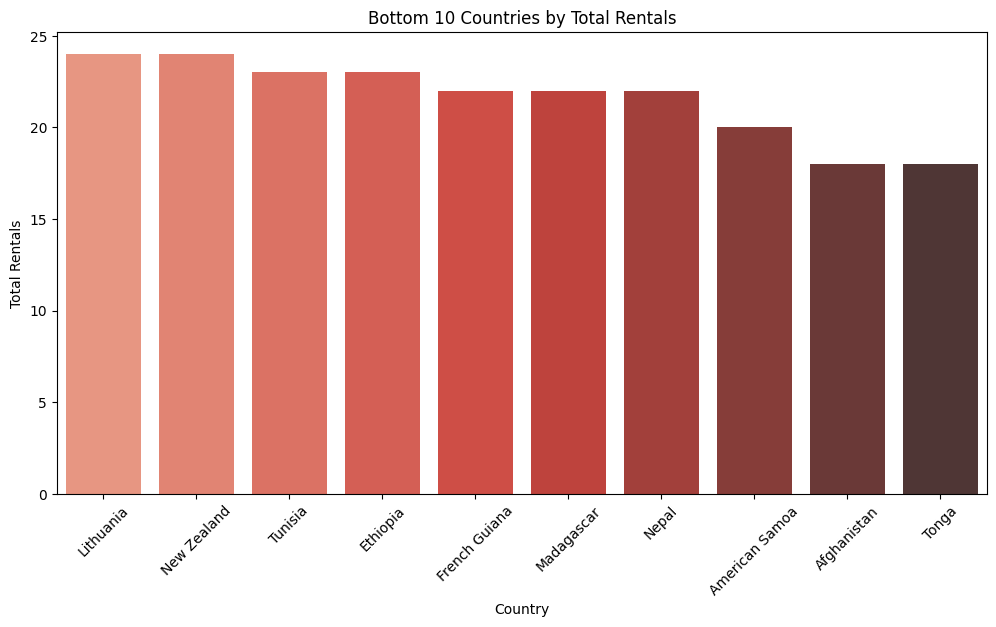

In [72]:
bottom_10_countries = country_rentals.tail(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=bottom_10_countries,
    x="country",
    y="times_rented",
    palette="Reds_d",
    hue="country",
    legend=False,
)
plt.title("Bottom 10 Countries by Total Rentals")
plt.xlabel("Country")
plt.ylabel("Total Rentals")
plt.xticks(rotation=45)
plt.show()

Shows the 10 countries that rent the least from bluckboster the smallest being tonga

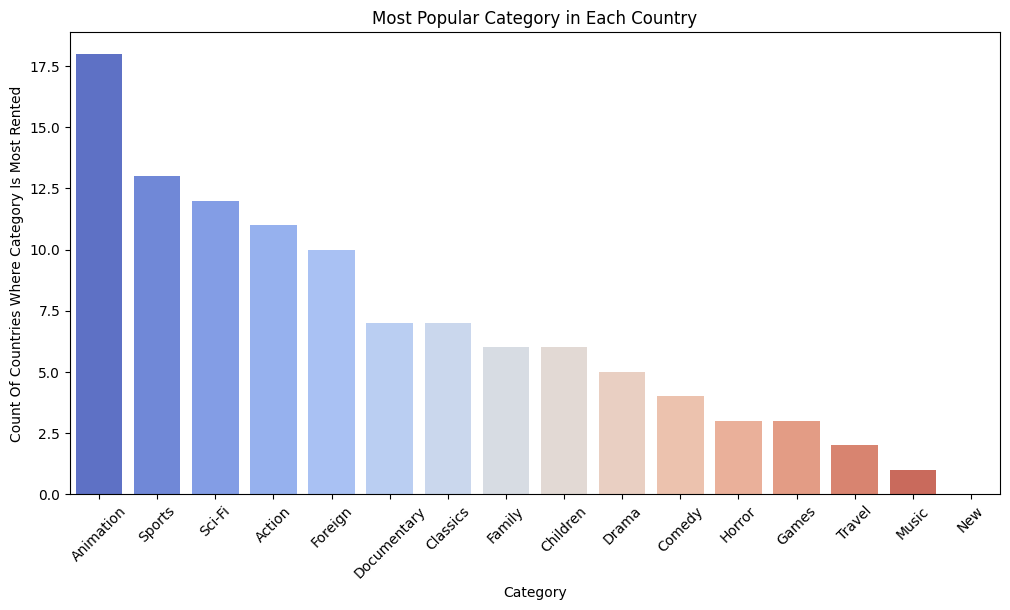

In [73]:
# Create a temporary copy for plotting
plot_counts = category_top_counts.copy()

# Get all unique categories
all_categories = clean_df["name"].unique()

# Find missing categories
missing_categories = [
    cat for cat in all_categories if cat not in plot_counts["category"].values
]

# Create a DataFrame for missing categories with 0 count
missing_df = pd.DataFrame({"category": missing_categories, "count": 0})

# Concatenate to include missing categories
plot_counts = pd.concat([plot_counts, missing_df], ignore_index=True)


# Sort by count descending
plot_counts = plot_counts.sort_values("count", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_counts, x="category", y="count", palette="coolwarm", hue='category', legend=False)
plt.title("Most Popular Category in Each Country")
plt.xlabel("Category")
plt.ylabel("Count Of Countries Where Category Is Most Rented")
plt.xticks(rotation=45)
plt.show()

Going by the top category by each country you can see that although sports is the most popular overall animation is actually a favourite of more countries this most likely being due to population differences. it also shows new is not a favourite of any country even though they are rent often when looking at the overall stats this is likely due to the temporary nature and limited variety of the category